# Load Required Libraries

In [1]:
import os
import spacy
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast
import plotly.express as px
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras
import transformers 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from transformers import TFAutoModel, AutoTokenizer
from transformers import AutoConfig
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
tqdm.pandas()

In [2]:
embedding_path = r"C:\Holmusk\analysis"

# Load spacy models

In [3]:
# Load the sapcy model
nlp_sm = spacy.load("en_core_web_sm")

In [4]:
nlp_lg = spacy.load("en_core_web_lg")

# Load Clinic Notes Data

In [20]:
data = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\cleaned_clinic_text.csv")

# Load Medical Keyword Pair

In [6]:
medical_terms = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\MedicalConcepts.csv")
medical_terms['Term1'] = medical_terms['Term1'].apply(lambda x: x.lower())
medical_terms['Term2'] = medical_terms['Term2'].apply(lambda x: x.lower())
medical_terms.drop_duplicates(keep='first', inplace=True)
medical_terms.shape

(558, 2)

# Below are few helper functions

In [7]:
def load_embedding(file_name = "bert_embedding.csv"):
    emb = pd.read_csv(os.path.join(embedding_path,file_name))
    emb.drop(['Unnamed: 0'], axis=1, inplace=True)
    return emb

In [8]:
def calculate_similarity(row):
    similarity = cosine_similarity([row['term1']], [row['term2']])[0][0]
    return similarity

In [9]:
def getEmbedding(row, nlp):
    doc = nlp(row)
    embedding = doc.vector
    return embedding

In [10]:
def plotKmeansClusteredEmbeddings(embeddings, model):
    kmeans = KMeans(n_clusters=3)
    cluster_labels = kmeans.fit_predict(embeddings)

    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.figure(figsize=(13, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'K-means Clustering of {model} Embeddings')
    plt.show()
    
    clustering_res = pd.DataFrame({'category':list(data['category']), 'label':list(kmeans.labels_)})
    
    print(f"K-Means clustering summary on {model}")
    for i in range(3):
        print(f"***********Data points in cluster: {i}  :**************")
        print(clustering_res[clustering_res['label']==i]['category'].value_counts())

In [11]:
import seaborn as sns

def plotEmbeddings(embeddings, categories, model):
    df = pd.DataFrame(embeddings)
    df["Data_Point"] = categories

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(df.drop(["Data_Point"], axis=1))

    df["TSNE_X"] = embeddings_tsne[:, 0]
    df["TSNE_Y"] = embeddings_tsne[:, 1]

    plt.figure(figsize=(12, 8))
    
    colors = {"Neurology": "red", "Gastroenterology": "green", "Cardiovascular / Pulmonary": "blue"}

    sns.scatterplot(x="TSNE_X", y="TSNE_Y", hue="Data_Point", data=df, palette=colors)
    
    plt.title(f"Embeddings Visualization with {model} Embedding size as: {len(embeddings[0])}")
    plt.xlabel("TSNE_X")
    plt.ylabel("TSNE_Y")

    plt.show()

# get embedding from pretrained word2vec from smaller spacy model

In [42]:
res_sm = data['notes'].apply(getEmbedding, args=(nlp_sm,))

In [43]:
pd.DataFrame(list(res_sm)).to_csv(os.path.join(embedding_path,'raw_word2vec_96_embedding.csv'))

# K-Means Clustering Result

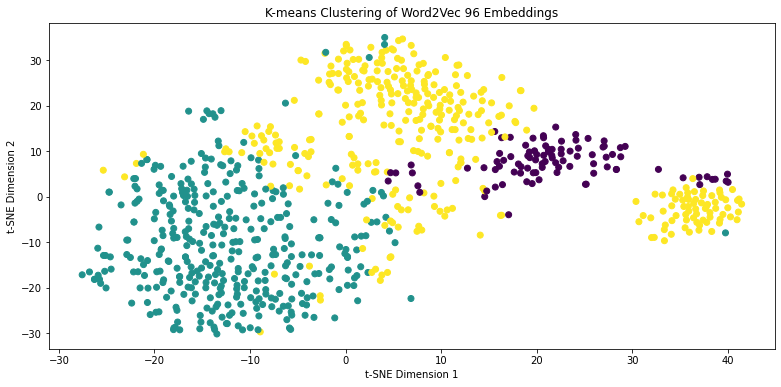

K-Means clustering summary on Word2Vec 96
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    58
Gastroenterology              24
Neurology                     12
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    198
Gastroenterology              123
Neurology                      53
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Neurology                     158
Cardiovascular / Pulmonary    115
Gastroenterology               77
Name: category, dtype: int64


In [44]:
res_sm = np.array(load_embedding(file_name = "raw_word2vec_96_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'Word2Vec 96')

Cluster 2 is getting confused greatly between neurology and cardiovascular by assigning 158 neurology points and 115 cardiovascular points to cluster 0. Same goes for cluster 1 as well in which model is confusing between cardiovascular  and gastroenterology. This of course is not a good result.

# Lets verify embedding quality by getting embedding for clinic notes data and then plotting it against category Neurology ,cardiovascular and Gastro

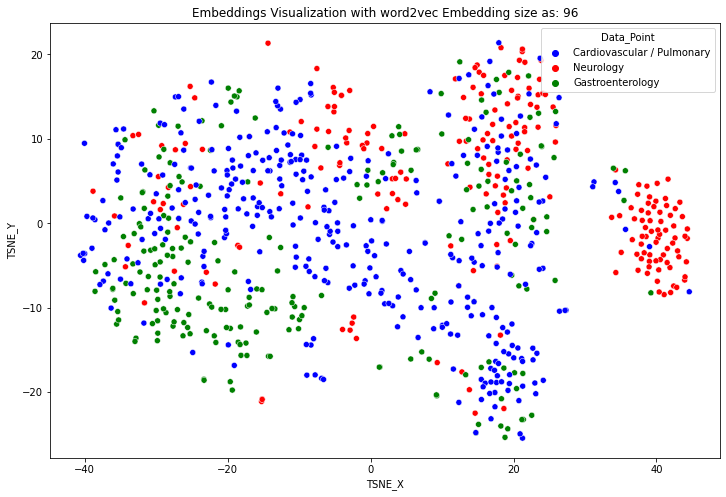

In [27]:
res_sm = np.array(load_embedding(file_name = "cleaned_raw_word2vec_96_embedding.csv"))
plotEmbeddings(list(res_sm), data['category'].values, 'word2vec')

<h3>Above embeddings are not good as no clear group can be seen

# get embedding for medical keywords and calculate similarity using word2vec_sm

In [26]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(getEmbedding, args=(nlp_sm,))
res2 = medical_terms["Term2"][:top].apply(getEmbedding, args=(nlp_sm,))
res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

w2v_sm = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   239.9576534051448
mean cosine_similarity =   0.43003153800964355


<h3>mean cosine similarity on keywod pair is just 0.43, which is not very good.

# get embedding from pretrained word2vec from larger spacy model

In [45]:
res_lg = data['notes'].apply(getEmbedding, args=(nlp_lg,))

In [46]:
pd.DataFrame(list(res_lg)).to_csv(os.path.join(embedding_path,'raw_word2vec_300_embedding.csv'))

# K-Means Clustering Result

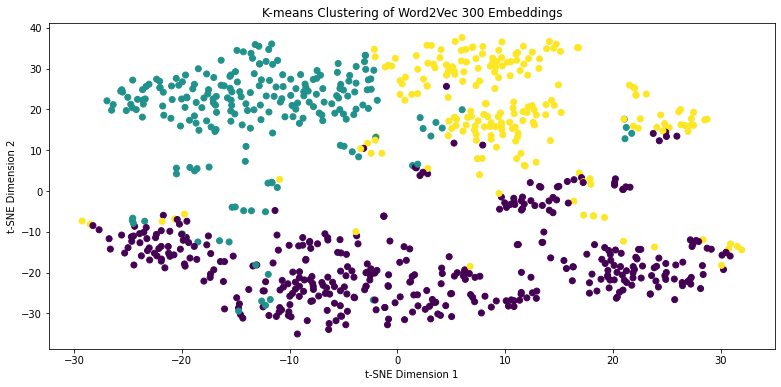

K-Means clustering summary on Word2Vec 300
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    203
Gastroenterology              136
Neurology                      49
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Neurology                     100
Cardiovascular / Pulmonary     63
Gastroenterology               60
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    105
Neurology                      74
Gastroenterology               28
Name: category, dtype: int64


In [47]:
res_sm = np.array(load_embedding(file_name = "raw_word2vec_300_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'Word2Vec 300')

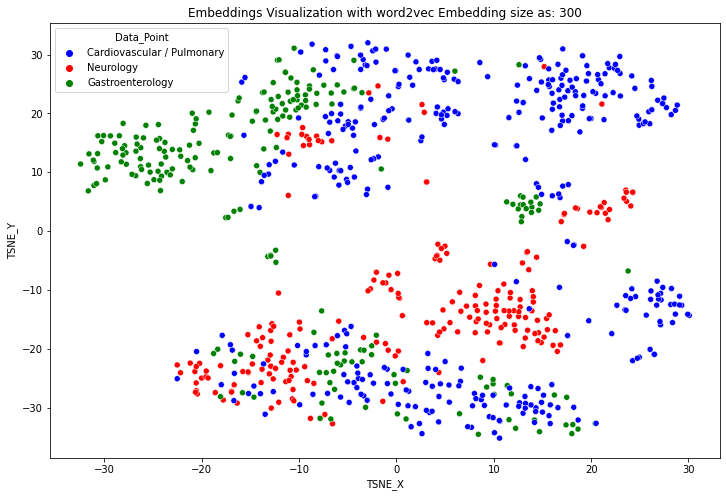

In [48]:
res_lg = np.array(load_embedding(file_name = "raw_word2vec_300_embedding.csv"))
plotEmbeddings(list(res_lg), data['category'].values, 'word2vec')

<h3>Above embedding's plot is better than word2vec small model

# get embedding for medical keywords and calculate similarity using word2vec_lg

In [17]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(getEmbedding, args=(nlp_lg,))
res2 = medical_terms["Term2"][:top].apply(getEmbedding, args=(nlp_lg,))
res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)
w2v_lg = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   128.0270563007798
mean cosine_similarity =   0.22943921387195587


<h3>mean cosine similarity on keywod pair is just 0.23, which is not very good

# Using Elmo to get Embedding

In [5]:
# Load the pre-trained ELMo model
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [21]:
def get_elmo_embedding(sentences):
    embeddings = elmo.signatures["default"](tf.constant([sentences]))["elmo"]
    sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
    return sentence_embeddings.numpy()[0]

In [22]:
res_elmo = data['notes'].apply(get_elmo_embedding)

In [ ]:
pd.DataFrame(list(res_elmo)).to_csv(os.path.join(embedding_path,'raw_elmo_pretrained_embeddings.csv'))

# K-Means Clustering Result

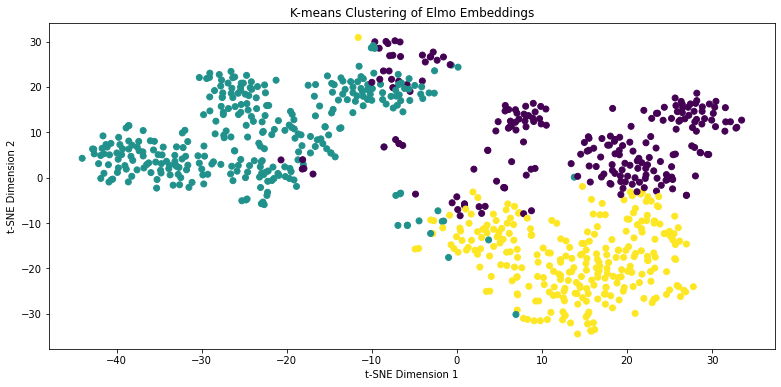

K-Means clustering summary on Elmo
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    135
Neurology                      58
Gastroenterology               28
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Neurology                     141
Cardiovascular / Pulmonary    113
Gastroenterology               70
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Gastroenterology              126
Cardiovascular / Pulmonary    123
Neurology                      24
Name: category, dtype: int64


In [143]:
res_sm = np.array(load_embedding(file_name = "raw_elmo_pretrained_embeddings.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'Elmo')

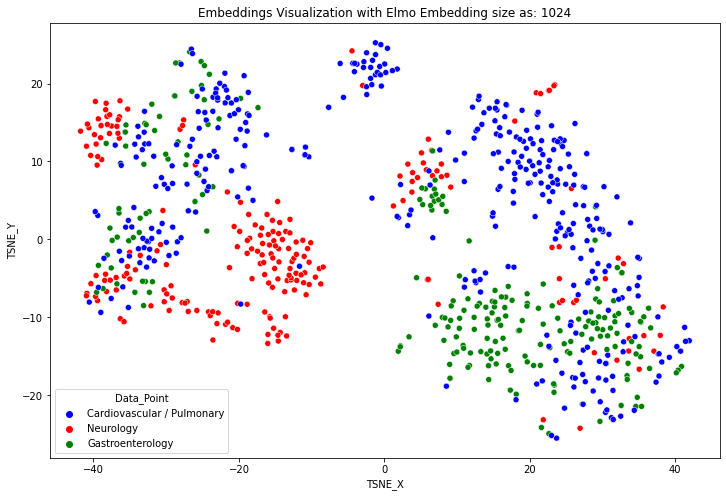

In [33]:
res_elmo = np.array(load_embedding(file_name = "raw_elmo_pretrained_embeddings.csv"))
plotEmbeddings(list(res_elmo), data['category'].values, 'Elmo')

<h3>Elmo embeddings are way better than word2vec embeddings

In [34]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_elmo_embedding)
res2 = medical_terms["Term2"][:top].apply(get_elmo_embedding)

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

elmo = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   308.23337239027023
mean cosine_similarity =   0.5523895


<h3>mean cosine similarity on keywod pair is just 0.55, which is not too bad

# Using BERT to Get Embedding

In [18]:
def get_bert_embedding(sentence, model, tokenizer):

    tokens = tokenizer.encode_plus(sentence, padding=True, truncation=True, max_length=512, return_tensors="tf")

    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    outputs = model(input_ids, attention_mask=attention_mask)

    hidden_states = outputs.last_hidden_state

    mask = tf.cast(tf.expand_dims(attention_mask, axis=-1), tf.float32)

    masked_hidden_states = hidden_states * mask

    sentence_representations = tf.reduce_sum(masked_hidden_states, axis=1) / tf.reduce_sum(mask, axis=1)
    return sentence_representations

# Bert Base Uncased

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

res_bert = data['notes'].apply(get_bert_embedding, args=(model,tokenizer))

In [40]:
res_bert1 = [res[0].numpy() for res in res_bert]
pd.DataFrame(res_bert1).to_csv(os.path.join(embedding_path,'raw_bert_embedding.csv'))

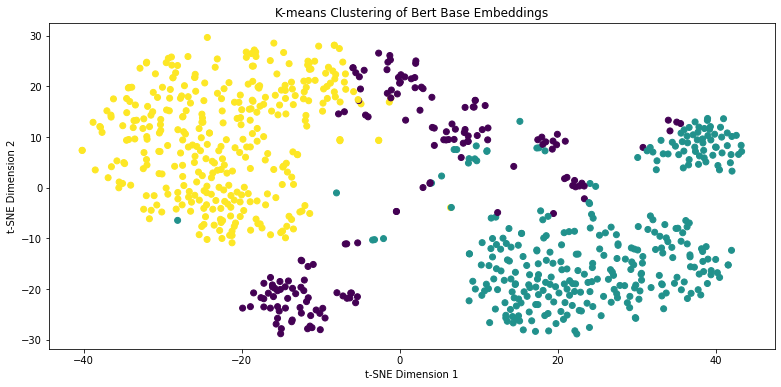

K-Means clustering summary on Bert Base
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    78
Neurology                     53
Gastroenterology              24
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Neurology                     145
Cardiovascular / Pulmonary    120
Gastroenterology               56
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    173
Gastroenterology              144
Neurology                      25
Name: category, dtype: int64


In [144]:
res_sm = np.array(load_embedding(file_name = "raw_bert_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'Bert Base')

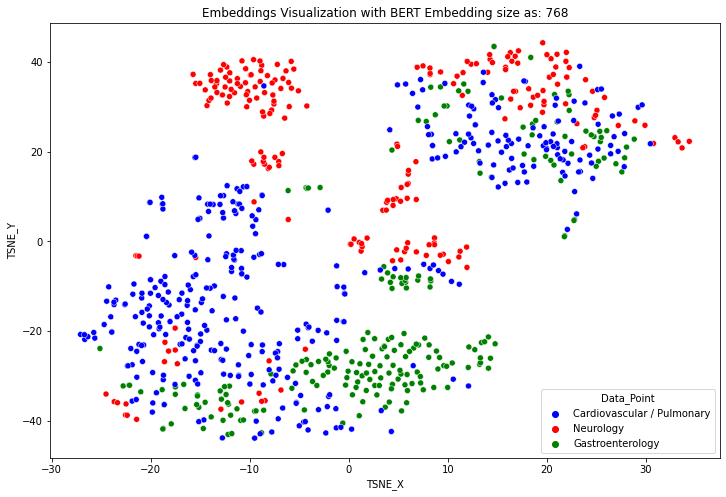

In [34]:
res_bert1 = np.array(load_embedding(file_name = "raw_bert_embedding.csv"))
plotEmbeddings(list(res_bert1), data['category'].values, 'BERT')

<h3>BERT embeddings are not good also not too bad

# get embedding for medical keywords and calculate similarity using BERT base

In [22]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding)
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding)

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   319.710486933589
mean cosine_similarity =   0.57295823097229


<h3>mean cosine similarity on keywod pair is 0.57, which is again not too good.

# Using BioBERT to Get Embedding. This model is trained on bio medical data

In [ ]:
bio_model_name = "dmis-lab/biobert-v1.1"
bio_tokenizer = AutoTokenizer.from_pretrained(bio_model_name)
bio_model = TFAutoModel.from_pretrained(bio_model_name, from_pt=True)

res_bio_bert = data['notes'].apply(get_bert_embedding, args=(bio_model,bio_tokenizer))

In [49]:
res_bio_bert1 = [res[0].numpy() for res in res_bio_bert]
pd.DataFrame(res_bio_bert1).to_csv(os.path.join(embedding_path,'raw_bio_bert_embedding.csv'))

# K-Means Clustering Result

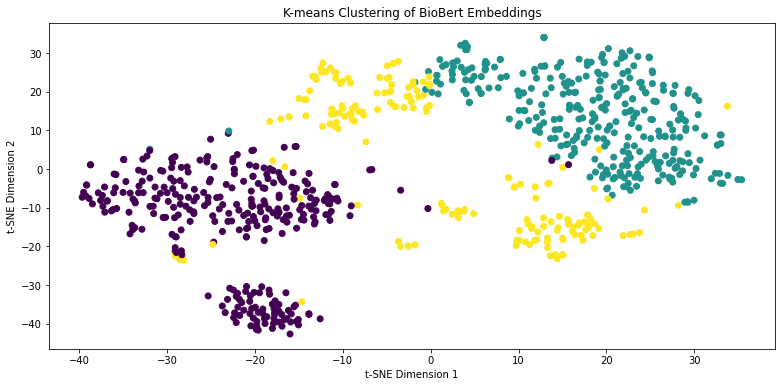

K-Means clustering summary on BioBert
***********Data points in cluster: 0  :**************
Neurology                     151
Cardiovascular / Pulmonary    106
Gastroenterology               53
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    156
Gastroenterology              146
Neurology                      25
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    109
Neurology                      47
Gastroenterology               25
Name: category, dtype: int64


In [145]:
res_sm = np.array(load_embedding(file_name = "raw_bio_bert_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'BioBert')

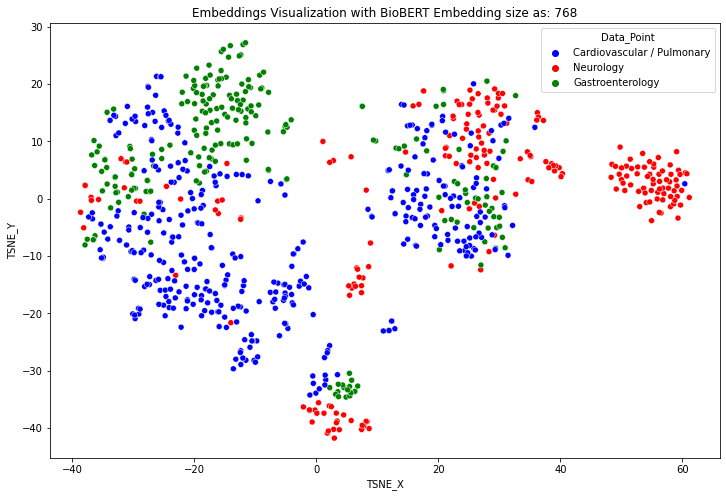

In [35]:
res_bio_bert1 = np.array(load_embedding(file_name = "raw_bio_bert_embedding.csv"))
plotEmbeddings(list(res_bio_bert1), data['category'].values, 'BioBERT')

 <h3>BioBert has produced the best embedding so far. above plot is the best plot we have seens so far

# get embedding for medical keywords and calculate similarity using BioBert

In [26]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(bio_model,bio_tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(bio_model,bio_tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

bio_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   447.63191509246826
mean cosine_similarity =   0.8022072911262512


<h3>best mean cosine similarity score we seen so far.

# Using ClinicalBert to get Embeddings. This model is trained on clinical notes

In [ ]:
clinic_model_name = "emilyalsentzer/Bio_ClinicalBERT"
clinic_tokenizer = AutoTokenizer.from_pretrained(clinic_model_name)
clinic_model = TFAutoModel.from_pretrained(clinic_model_name)

res_clinic_bert = data['notes'].apply(get_bert_embedding, args=(clinic_model, clinic_tokenizer))

In [ ]:
res_clinic_bert1 = [res[0].numpy() for res in res_clinic_bert]
pd.DataFrame(res_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_clinic_bert_embedding.csv'))

# K-Means Clustering Result

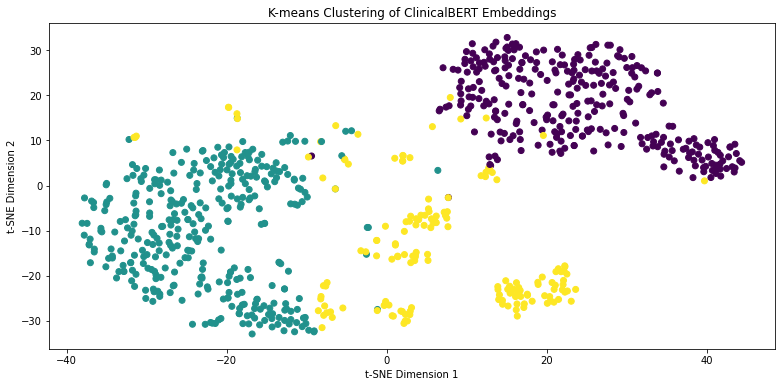

K-Means clustering summary on ClinicalBERT
***********Data points in cluster: 0  :**************
Neurology                     146
Cardiovascular / Pulmonary    103
Gastroenterology               50
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    182
Gastroenterology              147
Neurology                      26
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    86
Neurology                     51
Gastroenterology              27
Name: category, dtype: int64


In [38]:
res_sm = np.array(load_embedding(file_name = "raw_clinic_bert_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'ClinicalBERT')

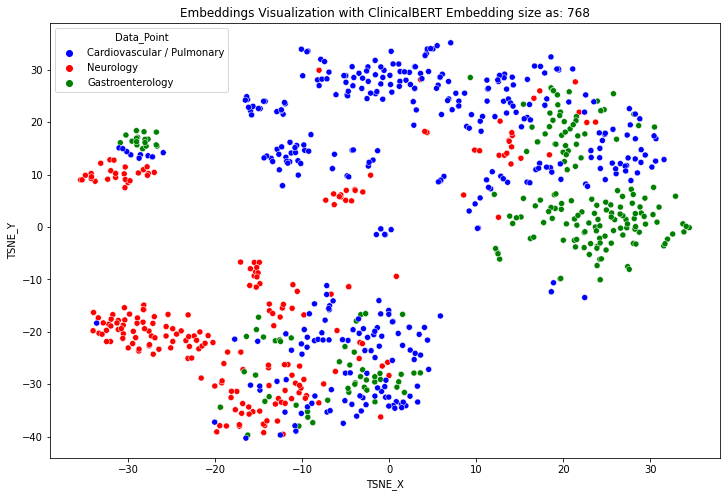

In [39]:
res_clinic_bert1 = np.array(load_embedding(file_name = "raw_clinic_bert_embedding.csv"))
plotEmbeddings(list(res_clinic_bert1), data['category'].values, 'ClinicalBERT')

 <h3>Clinical BERT seems even better than BioBERT

# get embedding for medical keywords and calculate similarity using ClincalBERT

In [24]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(clinic_model, clinic_tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(clinic_model, clinic_tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

clinical_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   453.973201751709
mean cosine_similarity =   0.8135718107223511


<h3>this mean cosine similarity is even better than BioBERT

# Using BlueBert to get Embeddings. This model is trained on clinical notes

In [59]:
blue_model_name = "bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12"
blue_tokenizer = AutoTokenizer.from_pretrained(blue_model_name)
blue_model = TFAutoModel.from_pretrained(blue_model_name, from_pt=True)

res_blue_bert = data['notes'].apply(get_bert_embedding, args=(blue_model,blue_tokenizer))

In [ ]:
res_blue_bert1 = [res[0].numpy() for res in res_blue_bert]
pd.DataFrame(res_blue_bert1).to_csv(os.path.join(embedding_path,'cleaned_raw_clinic_bert_embedding.csv'))

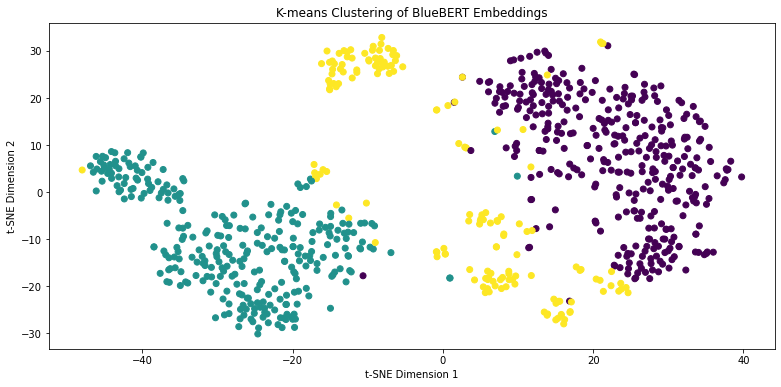

K-Means clustering summary on BlueBERT
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    183
Gastroenterology              147
Neurology                      26
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Neurology                     146
Cardiovascular / Pulmonary    106
Gastroenterology               50
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    82
Neurology                     51
Gastroenterology              27
Name: category, dtype: int64


In [35]:
res_sm = np.array(load_embedding(file_name = "cleaned_raw_clinic_bert_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'BlueBERT')

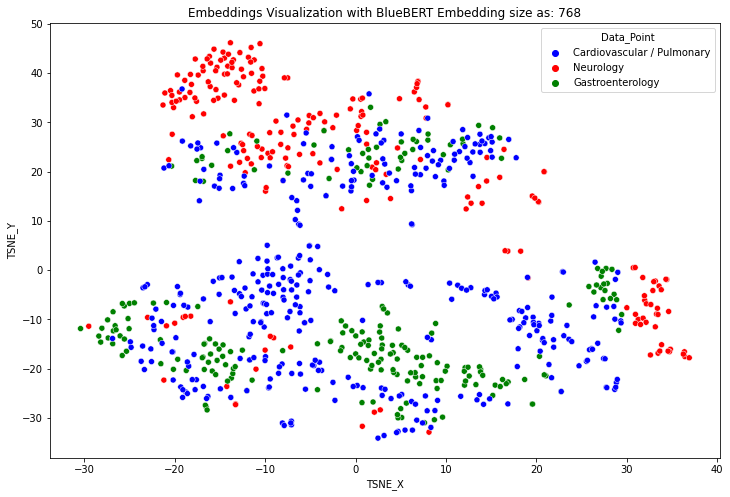

In [37]:
res_blue_bert1 = np.array(load_embedding(file_name = "raw_blue_bert_embedding.csv"))
plotEmbeddings(list(res_blue_bert1), data['category'].values, 'BlueBERT')

 <h3>Above plot does not show good embedding results

# get embedding for medical keywords and calculate similarity using BlueBERT

In [53]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(blue_model,blue_tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(blue_model,blue_tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

blue_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   404.4722881615162
mean cosine_similarity =   0.7248604893684387


<h3>mean cosine similarity too is not as good as it was with BuoBERT and ClinicalBERT

# Checking All Models perfoemce together on cosine similarity task

In [ ]:
chars = ['word2vec_small', 'word2vec_large', 'ELMO', 'bert', 'bio_bert', 'clinical_bert', 'blue_bert']
numbers = [round(np.mean(w2v_sm) * 100, 2), round(np.mean(w2v_lg) * 100, 2), round(np.mean(elmo) * 100, 2), round(np.mean(bert) * 100, 2),
           round(np.mean(bio_bert) * 100, 2), round(np.mean(clinical_bert) * 100, 2), round(np.mean(blue_bert) * 100, 2)]


pd.DataFrame({"chart": chars, "similarity_score" : numbers}).to_csv("similarity_score.csv")

In [96]:
similarity_score = pd.read_csv("similarity_score.csv")

chars = similarity_score['chart']
numbers = similarity_score['similarity_score']

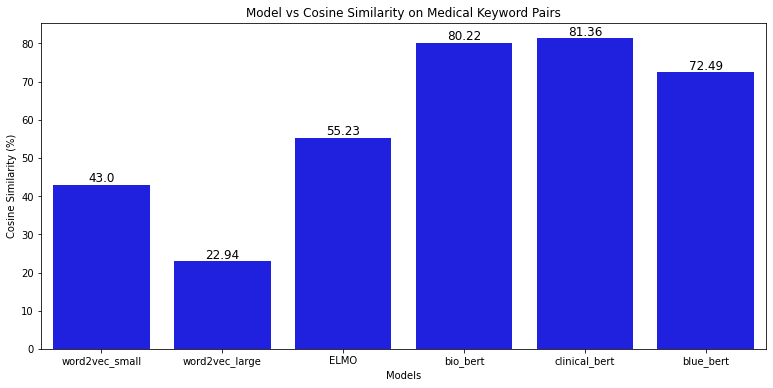

In [97]:
plt.figure(figsize=(13, 6))
ax = sns.barplot(x=chars, y=numbers, color='blue')

# Add annotations to each bar with increased font size
for i, v in enumerate(numbers):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=12)

plt.title('Model vs Cosine Similarity on Medical Keyword Pairs')
plt.xlabel('Models')
plt.ylabel('Cosine Similarity (%)')

plt.show()


# Lets Now Fine tune ClinicalBERT model further as it is the Best Model So far

<li>Code for fine tunning the models and preprocessing the data exists in other ipynb files
<li>Please refer preprocessing_data.ipynb fine to check preprocessing steps that i perfoemd.
<li>Please check model_tunning.ipynb fine to check model configuartion and architecture infromation
<li>I have uploaded all files on my gihub. link is below-

In [10]:
def get_embedding_from_finetuned_bert(sentence, tuned_model, tokenizer):
    
    max_len = 512
    tokens = tokenizer(sentence, truncation=True, padding=True, max_length=max_len, return_tensors="tf")
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    
    outputs = tuned_model([input_ids,attention_mask])
    
    hidden_states = outputs['last_hidden_state']

    mask = tf.cast(tf.expand_dims(attention_mask, axis=-1), tf.float32)

    masked_hidden_states = hidden_states * mask

    sentence_representations = tf.reduce_sum(masked_hidden_states, axis=1) / tf.reduce_sum(mask, axis=1)
    return sentence_representations

# Finetuned model on clinical notes

In [12]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
tuned_model = keras.models.load_model(r'C:\Holmusk\model\clinical_bert_fine_tuned_for_notes.h5', 
                                 custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
tuned_clinic_bert = data['notes'].apply(get_embedding_from_finetuned_bert, args=(tuned_model, tokenizer))
tuned_clinic_bert1 = [res[0].numpy() for res in tuned_clinic_bert]
pd.DataFrame(tuned_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_tuned_clinic_notes_bert_embedding_new.csv'))

# K-Means Clustering Result

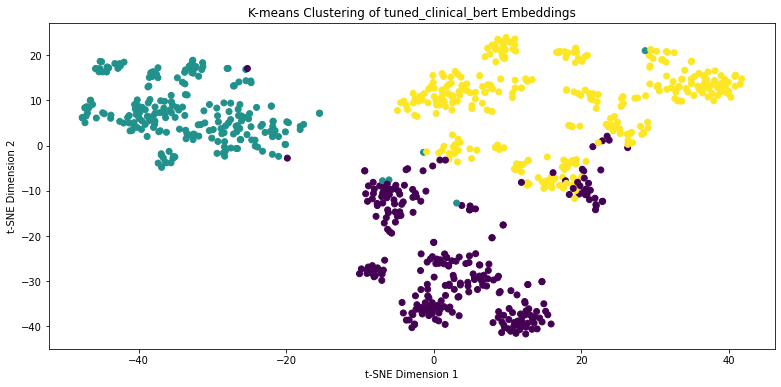

K-Means clustering summary on tuned_clinical_bert
***********Data points in cluster: 0  :**************
Gastroenterology              219
Cardiovascular / Pulmonary     49
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Neurology                     216
Cardiovascular / Pulmonary     10
Gastroenterology                4
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    312
Neurology                       7
Gastroenterology                1
Name: category, dtype: int64


In [148]:
res_sm = np.array(load_embedding(file_name = "raw_tuned_clinic_notes_bert_embedding_new.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'tuned_clinical_bert')

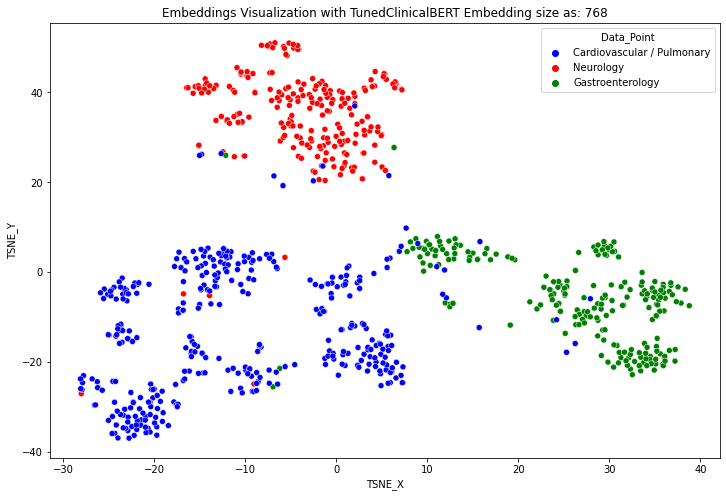

In [45]:
tuned_clinic_bert1 = np.array(load_embedding(file_name = "raw_tuned_clinic_notes_bert_embedding_new.csv"))
plotEmbeddings(list(tuned_clinic_bert1), data['category'].values, 'TunedClinicalBERT')

<h3>Training on clinical notes has improved the embedding to to categoris clinic notes pretty well

# get embedding for medical keywords and calculate similarity using notes_based_tuned_clinical_bert

In [14]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_embedding_from_finetuned_bert, args=(tuned_model, tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_embedding_from_finetuned_bert, args=(tuned_model, tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

finetuned_clinical_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   433.7339897155762
mean cosine_similarity =   0.7773011922836304


<h3> mean cosine similarity has got reduced a little, but still 0.77 it is a good score

# keyword pair based finetuned model 

In [10]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [61]:
keyword_tuned_model = keras.models.load_model(r'C:\Holmusk\model\clinical_bert_fine_tuned_for_medic_keywords.h5', 
                                 custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
keyword_tuned_clinic_bert = data['notes'].apply(get_embedding_from_finetuned_bert, args=(keyword_tuned_model, tokenizer))
keyword_tuned_clinic_bert1 = [res[0].numpy() for res in keyword_tuned_clinic_bert]
pd.DataFrame(tuned_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_keyword_tuned_bert_embedding_new.csv'))

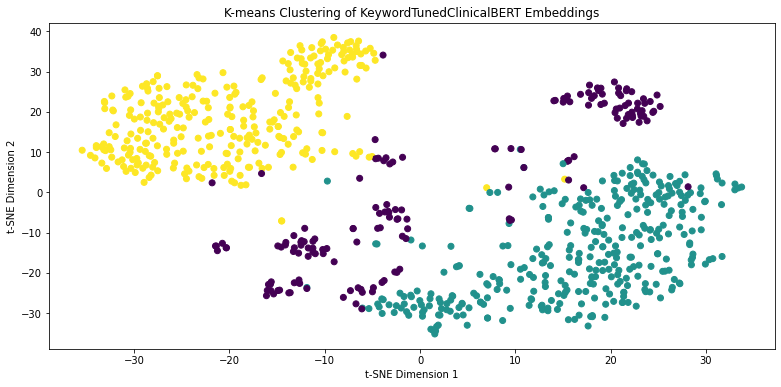

K-Means clustering summary on KeywordTunedClinicalBERT
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    83
Neurology                     51
Gastroenterology              27
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    182
Gastroenterology              147
Neurology                      26
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Neurology                     146
Cardiovascular / Pulmonary    106
Gastroenterology               50
Name: category, dtype: int64


In [149]:
res_sm = np.array(load_embedding(file_name = "raw_keyword_tuned_bert_embedding_new.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'KeywordTunedClinicalBERT')

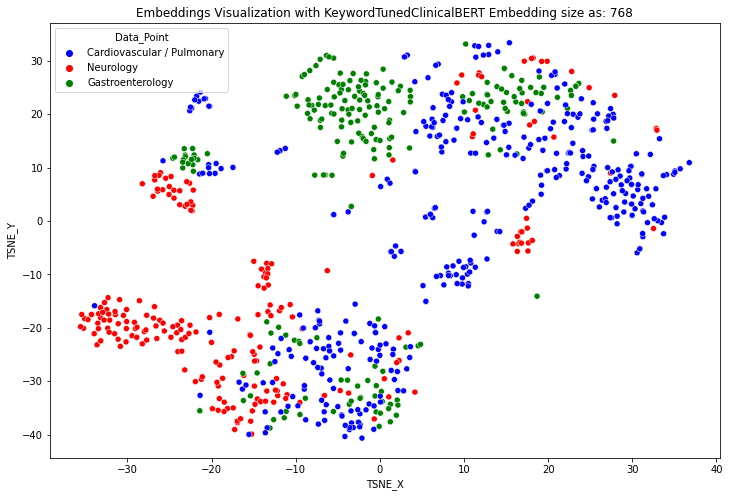

In [46]:
tuned_clinic_bert1 = np.array(load_embedding(file_name = "raw_keyword_tuned_bert_embedding_new.csv"))
plotEmbeddings(list(tuned_clinic_bert1), data['category'].values, 'KeywordTunedClinicalBERT')

<h3>Grouping of data is not too bad, but also not as good as we have seen just above

# get embedding for medical keywords and calculate similarity using keyword_based_tuned_clinical_bert

In [31]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_embedding_from_finetuned_bert, args=(keyword_tuned_model, tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_embedding_from_finetuned_bert, args=(keyword_tuned_model, tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

finetuned_clinical_bert_for_keywords = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   456.11888909339905
mean cosine_similarity =   0.8174178600311279


<h3>This is the best cosine similarity that we have seen so far.

# keyword pair and clinical notes data based finetuned model 

In [ ]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
bert_model.load_weights("C:\Holmusk\model\clinic_noes_and_keyword_based_trained_model.h5")

In [ ]:
keyword_clinic_tuned_clinic_bert = data['notes'].apply(get_bert_embedding, args=(bert_model, tokenizer))
keyword_clinic_tuned_clinic_bert1 = [res[0].numpy() for res in keyword_clinic_tuned_clinic_bert]
pd.DataFrame(keyword_clinic_tuned_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_clinc_keyword_tuned_bert_embedding.csv'))

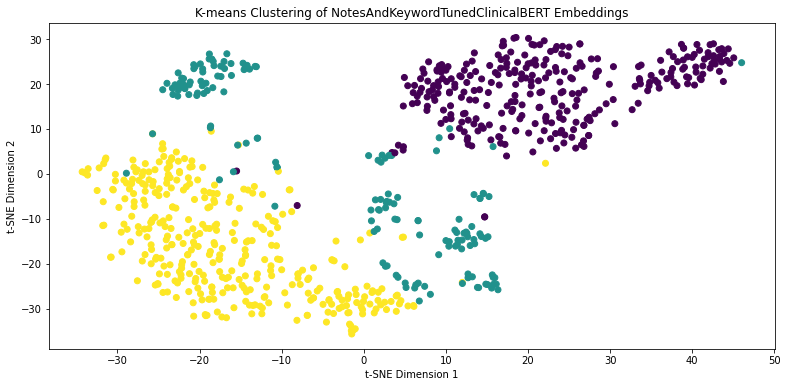

K-Means clustering summary on NotesAndKeywordTunedClinicalBERT
***********Data points in cluster: 0  :**************
Neurology                     146
Cardiovascular / Pulmonary    106
Gastroenterology               50
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    82
Neurology                     51
Gastroenterology              27
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    183
Gastroenterology              147
Neurology                      26
Name: category, dtype: int64


In [150]:
res_sm = np.array(load_embedding(file_name = "raw_keyword_tuned_bert_embedding_new.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'NotesAndKeywordTunedClinicalBERT')

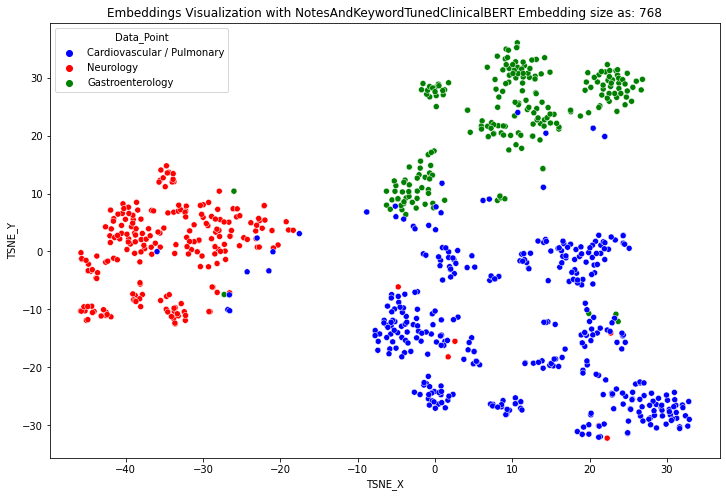

In [140]:
keyword_clinic_tuned_clinic_bert1 = np.array(load_embedding(file_name = "raw_clinc_keyword_tuned_bert_embedding.csv"))
plotEmbeddings(list(keyword_clinic_tuned_clinic_bert1), data['category'].values, 'NotesAndKeywordTunedClinicalBERT')

<h3>On training both type of data clinic notes and keyword pair, grouping has improved.

In [65]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(bert_model,tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(bert_model,tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   436.2237065434456
mean cosine_similarity =   0.78176296


<h3>Cosine similarity score too has improved as compared to the model which was only trained on clinic notes

# Lets see all model's performence once again on similarity task

In [ ]:

chars = ['word2vec_small', 'word2vec_large', 'ELMO', 'bert', 'bio_bert', 'clinical_bert', 'blue_bert','clinic_notes_finetuned_bert',
         "keyword_based_finetuned_bert", "keyword_clinic_tuned_clinic_bert1"]
numbers = [round(np.mean(w2v_sm) * 100, 2), round(np.mean(w2v_lg) * 100, 2), round(np.mean(elmo) * 100, 2), round(np.mean(bert) * 100, 2),
           round(np.mean(bio_bert) * 100, 2), round(np.mean(clinical_bert) * 100, 2), round(np.mean(blue_bert) * 100, 2),
          round(np.mean(finetuned_clinical_bert) * 100, 2), round(np.mean(finetuned_clinical_bert_for_keywords) * 100, 2),
          round(np.mean(finetuned_clinical_bert_for_keywords_and_notes) * 100, 2)]

In [101]:
pd.DataFrame({"chart": chars, "similarity_score" : numbers}).to_csv("all_model_similarity.csv")

In [106]:
similarity_score = pd.read_csv("all_model_similarity.csv")

chars = similarity_score['chart']
numbers = similarity_score['similarity_score']

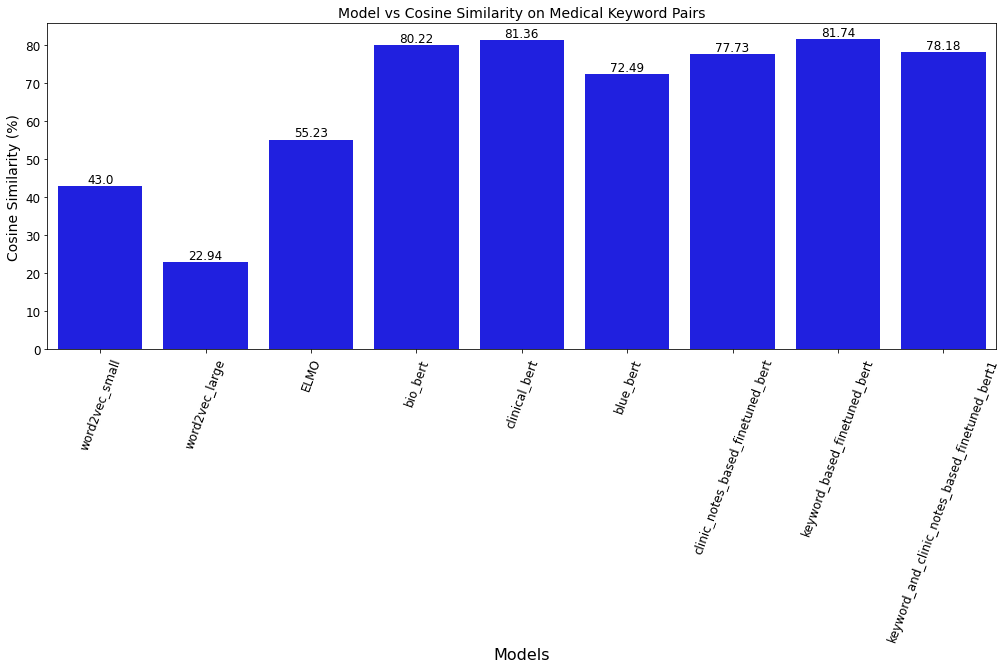

In [107]:

plt.figure(figsize=(17, 6))
ax = sns.barplot(x=chars, y=numbers, color='blue')

for i, v in enumerate(numbers):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=12)

plt.title('Model vs Cosine Similarity on Medical Keyword Pairs', fontsize=14)
plt.xlabel('Models', fontsize=16)
plt.ylabel('Cosine Similarity (%)', fontsize=14)


plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)

plt.show()


<h3>Below is the graph for only finetuned models

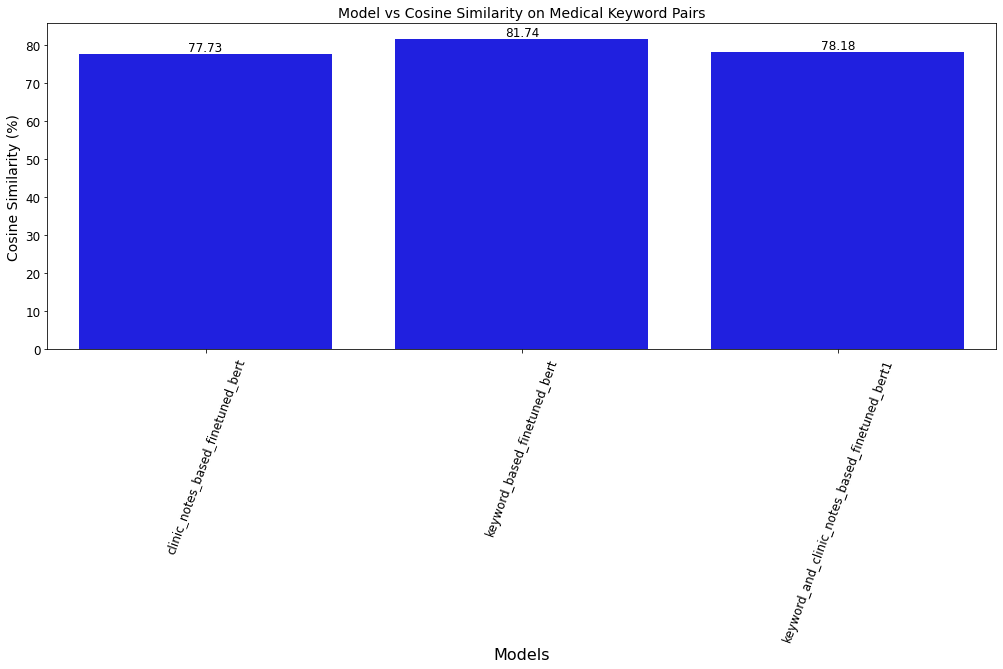

In [82]:
plt.figure(figsize=(17, 6))
ax = sns.barplot(x=chars[-3:], y=numbers[-3:], color='blue')

for i, v in enumerate(numbers[-3:]):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=12)

plt.title('Model vs Cosine Similarity on Medical Keyword Pairs', fontsize=14)
plt.xlabel('Models', fontsize=16)
plt.ylabel('Cosine Similarity (%)', fontsize=14)


plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)

plt.show()